# 1) Executive Summary #

I started this competition to practise exploratory data analysis and advanced regression techniques on a dataset with a relatively large number of predictors. 

I would like to credit __[Pedro Marcelino](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python)__ and __[Erik Bruin](https://www.kaggle.com/code/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda)__, whose work I referenced in the exploratory data analysis. 

# 2) Introduction #

Competition details can be found at this __[link](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)__. The description is reproduced here in the notebook as well: 

---

Ask a home buyer to describe their dream house, and they probably won’t begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition’s dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

# 3) Loading and Exploring Data #

## 3.1) Loading packages used ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

In [2]:
train = pd.read_csv('./datasets/train.csv', index_col='Id')

## 3.2) Data size and structure ##

The dataset contains 79 predictors and 1 response variable:

In [3]:
train.shape

(1460, 80)

In [4]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

# 4) Exploring some of the most important variables #

## 4.1) Dependent Variable: SalePrice ##

Let's look at the distribution of sale prices first. 

In [6]:
#descriptive statistics summary
labels = train['SalePrice']
labels.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [7]:
print(labels.median())

163000.0


In [8]:
mean_saleprice = labels.mean()
median_saleprice = labels.median()

As a sanity check, it's a good sign that the minimum price is non-negative. Mislabelled data with negative values would hurt the predictive power of our model subsequently. 

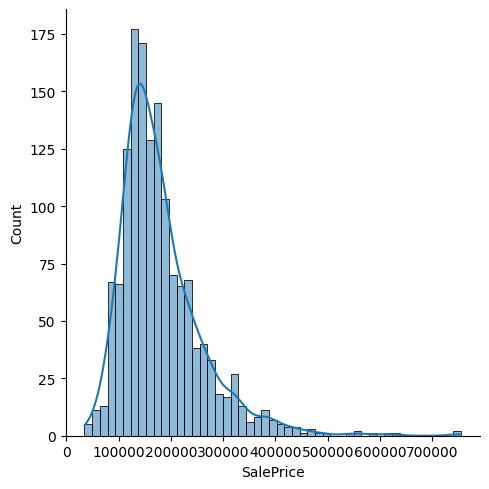

In [9]:
#histogram
sns.displot(labels,kde='True');

From the plot, we can see that the sale prices:
- Deviate from the normal distribution

- Are skewed positively

- Show peakedness

In [10]:
#skewness
print("Skewness: %f" % labels.skew())

Skewness: 1.882876


In a positively skewed distribution, the mean of the data is greater than the median, which in turn is greater than the mode. A (Pearson's second) coefficient of skewness that is greater than 1 indicates extreme skewness.   

For distributions with a positive skew, we can apply a log transformation subsequently to approximate a normal distribution. 

In [11]:
#kurtosis
print("Kurtosis: %f" % labels.kurt())

Kurtosis: 6.536282


Excess Kurtosis is used to compare the kurtosis coefficient with that of the normal distribution. 

Since normal distributions have a kurtosis of 3, excess kurtosis is calculated by subtracting kurtosis by 3:

In [12]:
print("Excess Kurtosis: %f" % (labels.kurt() - 3)) #Excess Kurtosis = Kurt - 3

Excess Kurtosis: 3.536282


An excess kurtosis of > 3 indicates a leptokurtic (or heavy-tailed) distribution. 

This is unsurprising - from the distribution plot above, we can see that sale prices has a long and skinny tail, and therefore higher chances of outliers. 

## 4.2) Most important predictors of sale price ##

There are 79 variables in total, and clearly we will not be able to include all of them in our model to prevent overfitting. Many of the variables are likely correlated anyway.

As a preliminary approach, we can collapse our variables into categories that are likely important predictors of sale price:

1) Location

2) Size of the House

3) Condition of the House

4) Exogenous factors*

_(Exogenous factors refer to factors that have nothing to do with the inherent 'quality' of the house. Examples would include seasonality (MoSold) or the financial crisis (YrSold)_ 

Let's start off with the first - location. The most applicable column would be 'Neighborhood'.

### 4.2.1) Location:  'Neighborhood' ###

In [13]:
train['Neighborhood'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1460 entries, 1 to 1460
Series name: Neighborhood
Non-Null Count  Dtype 
--------------  ----- 
1460 non-null   object
dtypes: object(1)
memory usage: 22.8+ KB


It's good to know that there are no missing values. 

'Neighborhood' is a categorical variable, so we'd have to encode them subsequently before we can use them in our model.

In [14]:
train['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

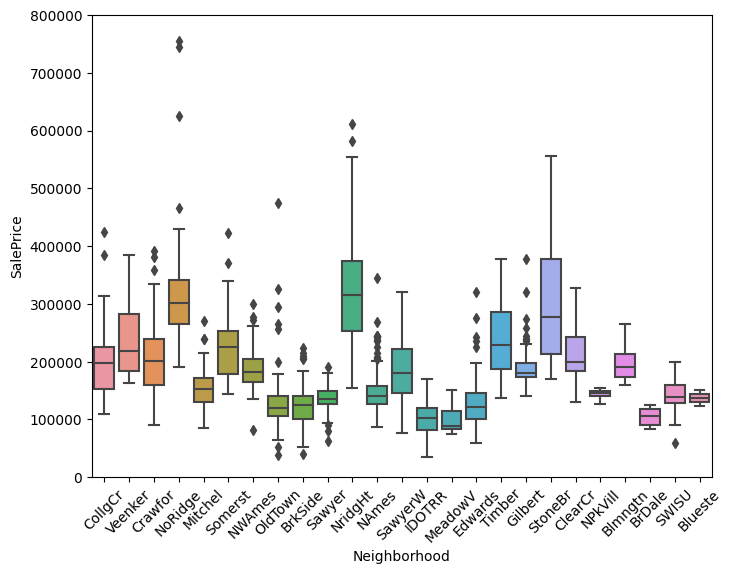

In [15]:
#box plot neighborhood/saleprice
var = 'Neighborhood'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
plt.xticks(rotation=45)
fig.axis(ymin=0, ymax=800000);

Note that there are 25 neighborhoods - having that many dummy variables may make the interpretation of our coefficients difficult later on, and might also result in overfitting. There are also some neighborhoods with very few data points. The presence of imbalanced classes mean that binning the similar neighborhoods together may help reduce the bias in the model. We'll bin the neighborhoods under the feature engineering section later. 

### 4.2.2) Condition of the House ###

There are many variables that correlate with the size and condition of the house. 

Let's start by examining a simple correlation matrix between the variables and SalePrice, and then select our candidate variables from there.

/var/folders/lw/rrbkgcqn1rd5b065dkf8ctwr0000gn/T/ipykernel_66605/3490709552.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = train.corr()


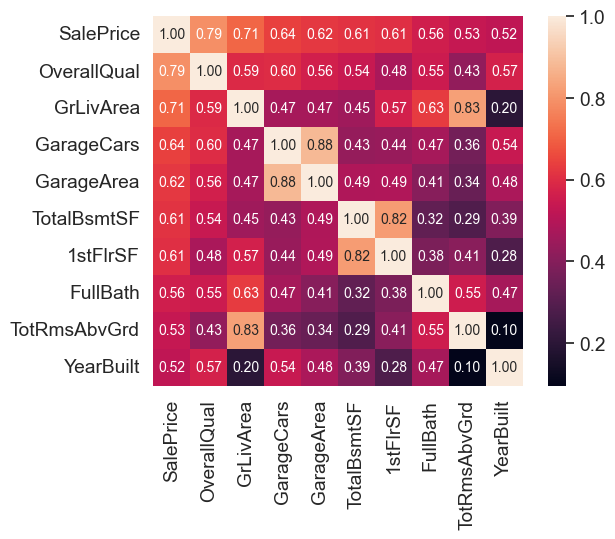

In [16]:
#saleprice correlation matrix
corrmat = train.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### 4.2.2.1) Examining OverallQual ####

OverallQual is the most correlated with SalePrice. 

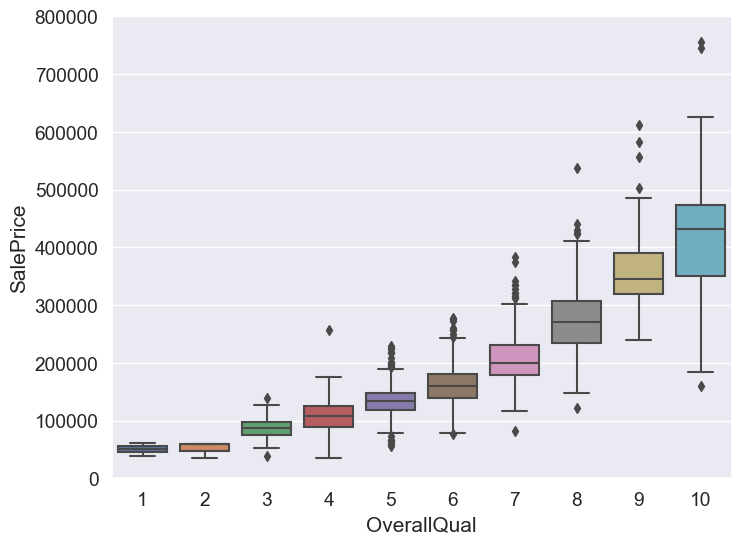

In [17]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

OverallQual seems to be a great categorical variable to use in our model. 

Based on the ordinal encoding, we can see that there appears to be a linear relationship between the quality of the house and the sale price. 

### 4.2.3) Examining GrLivArea& TotalBsmtSF ###

GrLivArea captures the living area square feet, while TotalBsmtSF captures the total squarefeet of the basement area. 

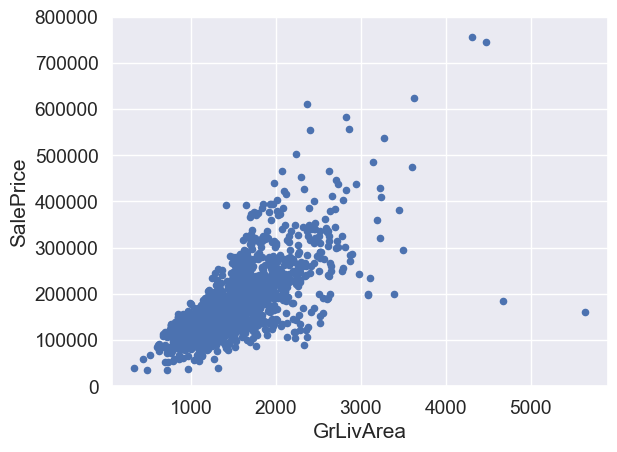

In [18]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

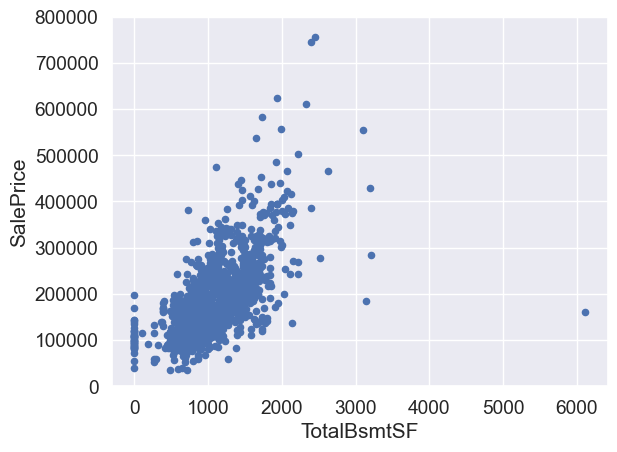

In [19]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Both predictors appear to have a linear relationship with SalePrice. 

There is some moderate correlation between the two (r = 0.45), which we will take note for now. 

### 4.2.4) Exogenous Factors ###

#### 4.2.4.1) Sale Condition & Sale Type ####

Location, size and condition should account for most of the variations in sale price, but there might be exceptional circumstances that result in anomalies (e.g. fire-sales).

SaleCondition is one predictor that may help capture some of the anomalies.

In [20]:
train['SaleCondition'].value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

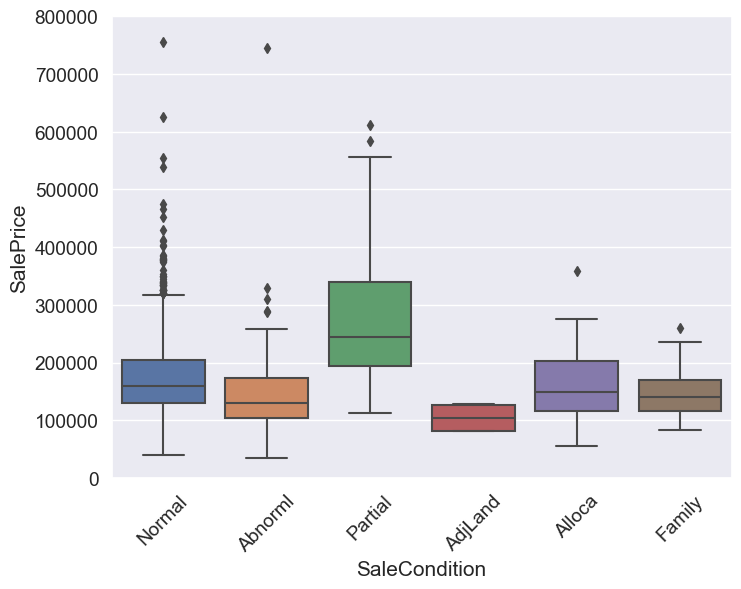

In [21]:
#box plot salecondition/saleprice
var = 'SaleCondition'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
plt.xticks(rotation=45)
fig.axis(ymin=0, ymax=800000);

Majority of sales were normal sales. 

As the data is non-ordinal, it is difficult to discern a clear trend from the visualization alone. 

Let's do the same for Sale Type. 

In [22]:
train['SaleType'].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

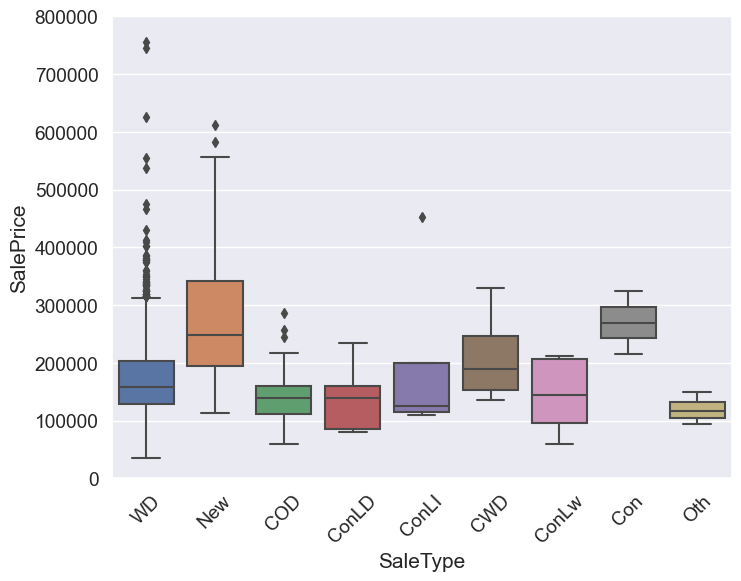

In [23]:
#box plot sale type/saleprice
var = 'SaleType'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
plt.xticks(rotation=45)
fig.axis(ymin=0, ymax=800000);

From the box plots, SaleCondition and SaleType do not appear to be strong predictors for sale prices. We will also need to bin several categories together due to the small sample sizes. 

#### 4.2.4.2) MoSold & YrSold ####

In [24]:
# groupby YrSold & MoSold to estimate the median sale price
var1, var2 = 'YrSold', 'MoSold'
median_by_YrMoSold = train.groupby([var1,var2])['SalePrice'].agg('median')
median_by_YrMoSold = median_by_YrMoSold.reset_index(level=[0,1])
median_by_YrMoSold['YrMo'] = median_by_YrMoSold['YrSold'].astype(str) + '-' + median_by_YrMoSold['MoSold'].astype(str)
# groupby YrSold & MoSold to estimate the mean sale price
mean_by_YrMoSold = train.groupby([var1,var2])['SalePrice'].agg('mean')
mean_by_YrMoSold = mean_by_YrMoSold.reset_index(level=[0,1])
mean_by_YrMoSold['YrMo'] = mean_by_YrMoSold['YrSold'].astype(str) + '-' + mean_by_YrMoSold['MoSold'].astype(str)

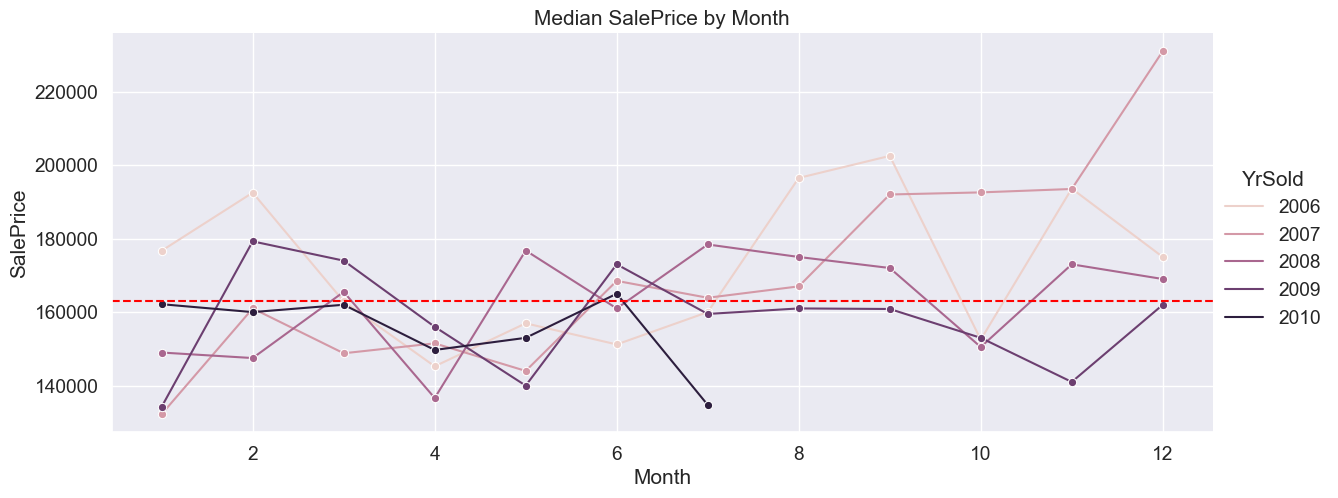

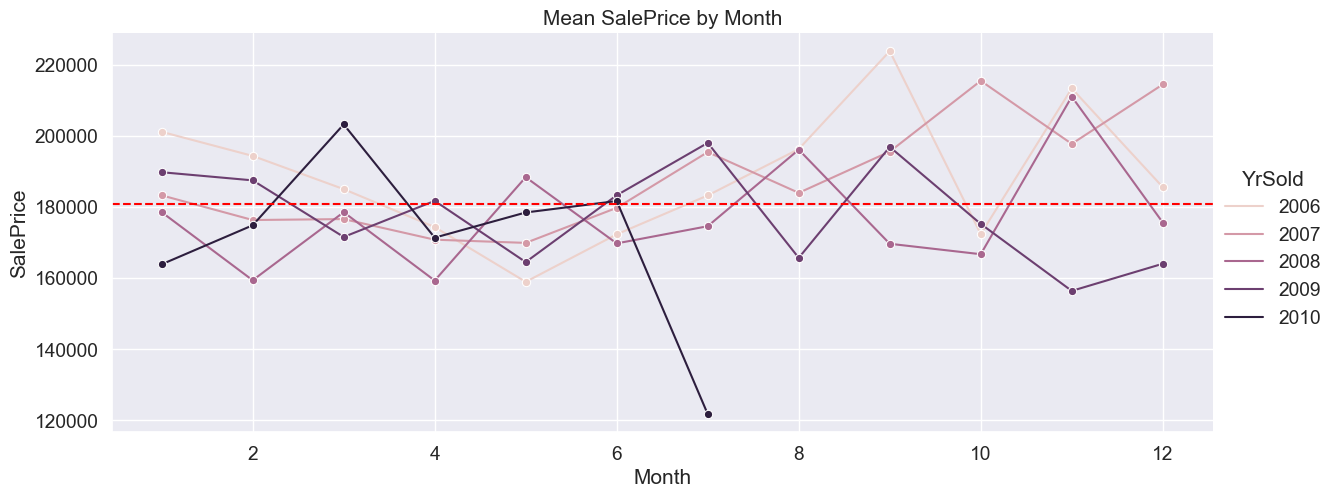

In [25]:
# plot the data
sns.relplot(kind='line', data=median_by_YrMoSold, x='MoSold', y='SalePrice', hue='YrSold', aspect=2.5, marker='o')
plt.title("Median SalePrice by Month")
plt.xlabel('Month')
plt.axhline(y = median_saleprice, linestyle='dashed', color='red')
plt.show()

sns.relplot(kind='line', data=mean_by_YrMoSold, x='MoSold', y='SalePrice', hue='YrSold', aspect=2.5, marker='o')
plt.title("Mean SalePrice by Month")
plt.xlabel('Month')
plt.axhline(y = mean_saleprice, linestyle='dashed', color='red')
plt.show()

From the overlapping plots of median and mean price by month, we can see a seasonal trend.

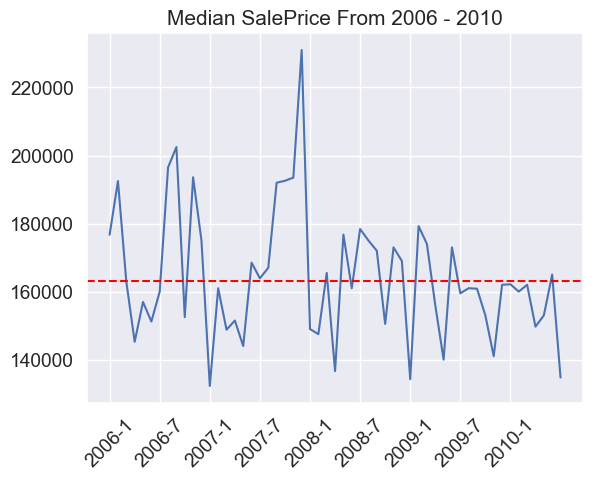

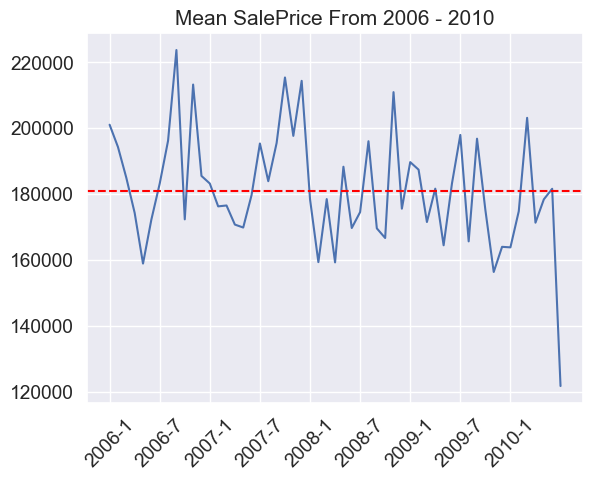

In [26]:
plt.plot(median_by_YrMoSold['YrMo'], median_by_YrMoSold['SalePrice'])
plt.xticks(ticks = range(0, 54, 6),labels= median_by_YrMoSold['YrMo'][0:54:6],rotation=45)
plt.title('Median SalePrice From 2006 - 2010')
plt.axhline(y = median_saleprice, linestyle='dashed', color='red')
plt.show()

plt.plot(mean_by_YrMoSold['YrMo'], mean_by_YrMoSold['SalePrice'])
plt.xticks(ticks = range(0, 54, 6),labels= mean_by_YrMoSold['YrMo'][0:54:6],rotation=45)
plt.title('Mean SalePrice From 2006 - 2010')
plt.axhline(y = mean_saleprice, linestyle='dashed', color='red')
plt.show()

There is a noticeable dropoff of the mean sale price after 2009, likely due to the financial crisis.

## 5) Missing Data ##

In handling missing data, there are a few things we need to consider:

1) Is there a pattern to the missing data?

2) Is the missing data likely to be important in our model?

We need to consider the two factors above before deciding whether we should remove or impute the values. 

In [27]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


There are many variables, such as PoolQC and MiscFeature that have a lot of missing values. 

Let's take a closer look at the data points that have an entry for 'PoolQC':

In [28]:
pool = train.dropna(subset=['PoolQC'])
pool['SalePrice'].describe()

count         7.000000
mean     288138.571429
std      206071.850935
min      160000.000000
25%      176000.000000
50%      235000.000000
75%      262485.000000
max      745000.000000
Name: SalePrice, dtype: float64

In [29]:
pool['SalePrice']

Id
198     235000
811     181000
1171    171000
1183    745000
1299    160000
1387    250000
1424    274970
Name: SalePrice, dtype: int64

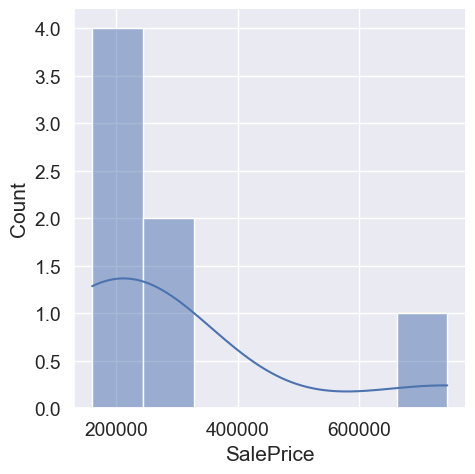

In [30]:
sns.displot(pool['SalePrice'],kde='True');

In [31]:
remaining = train[train['PoolQC'].isnull()]
remaining['SalePrice'].describe()

count      1453.000000
mean     180404.663455
std       78168.872519
min       34900.000000
25%      129900.000000
50%      162900.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

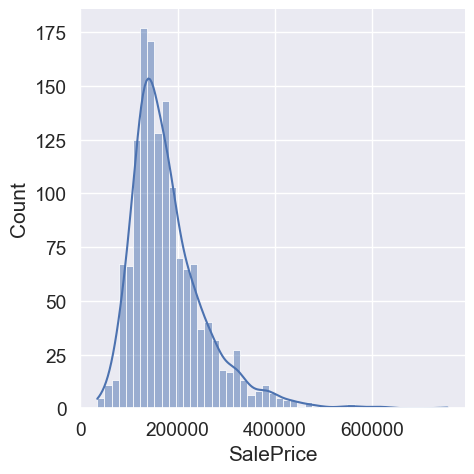

In [32]:
sns.displot(remaining['SalePrice'],kde='True');

The mean sale price for houses with PoolQC is 288000 dollars, almost 100000 dollars more than the mean of the remaining houses! 

It makes sense that such features belong to the really expensive or luxurious houses only, and are therefore missing in most of the data points. 

We can omit them for now and evaluate how well our model performs. If, for instance, we find that our model significantly underperforms when it comes to the outliers, then we can consider adding these features with an indicator variable such that the presence of these features would tell our model to predict a higher price.

Now let's look at the next category of variables - 'GarageX'. 

All of them have the same number of missing values. Let's check if it's the same rows for each of the variables:

In [33]:
GarageX_columns = ['GarageFinish', 'GarageYrBlt', 'GarageType', 'GarageQual', 'GarageCond']
indices = []
#Extract the indices of the missing values in those 4 columns
for col in GarageX_columns:
    bool_series = pd.isnull(train[col])
    null_values = train[bool_series][col].index
    indices.append(null_values)

In [34]:
#Stack the arrays
stacked_indices = np.vstack(indices)

#Get the differentiation along the axis of stacking; check if all differentiations are equal to zeros
(np.diff(stacked_indices, axis=0) == 0).all()

True

As we thought, the missing values in the GarageX columns belong to the same houses. 

These variables are likely to be strongly correlated with GarageCar, which has no missing values. So we can safely remove the GarageX columns for now. 

Let's do the same investigation for the BasementX columns. 

In [35]:
BsmtX_columns = ['BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtCond']
indices = []
#Extract the indices of the missing values in those 5 columns
for col in BsmtX_columns:
    bool_series = pd.isnull(train[col])
    null_values = train[bool_series][col].index
    indices.append(null_values)

In [36]:
indices

[Int64Index([  18,   40,   91,  103,  157,  183,  260,  333,  343,  363,  372,
              393,  521,  533,  534,  554,  647,  706,  737,  750,  779,  869,
              895,  898,  985, 1001, 1012, 1036, 1046, 1049, 1050, 1091, 1180,
             1217, 1219, 1233, 1322, 1413],
            dtype='int64', name='Id'),
 Int64Index([  18,   40,   91,  103,  157,  183,  260,  343,  363,  372,  393,
              521,  533,  534,  554,  647,  706,  737,  750,  779,  869,  895,
              898,  949,  985, 1001, 1012, 1036, 1046, 1049, 1050, 1091, 1180,
             1217, 1219, 1233, 1322, 1413],
            dtype='int64', name='Id'),
 Int64Index([  18,   40,   91,  103,  157,  183,  260,  343,  363,  372,  393,
              521,  533,  534,  554,  647,  706,  737,  750,  779,  869,  895,
              898,  985, 1001, 1012, 1036, 1046, 1049, 1050, 1091, 1180, 1217,
             1219, 1233, 1322, 1413],
            dtype='int64', name='Id'),
 Int64Index([  18,   40,   91,  103,  157,  18

With the smaller number of missing values in the BsmtX columns, a simple visual inspection suffices to show that they come from mostly the same houses. As the BsmtX columns are likely to be strongly correlated with TotalBsmtSF, we can omit them in our analysis for now as well. 

Finally, doing a quick inspection of the MasVnrType and MasVnrArea columns:

In [37]:
indices = []
#Extract the indices of the missing values in those 5 columns
for col in ['MasVnrType','MasVnrArea']:
    bool_series = pd.isnull(train[col])
    null_values = train[bool_series][col].index
    indices.append(null_values)

In [38]:
np.array_equal(indices[0], indices[1])

True

The 8 missing values come from the same rows, and they are likely to be strongly correlated with OverallQual. So we can omit them too.

The remaining missing value is in the 'Electrical' column. One missing value will not affect our model much, so we can remove that row in our analysis for now. 

In [39]:
#remove row with missing value in 'Electrical'
train = train.drop([train[train['Electrical'].isnull()].index.values.astype(int)[0]])
#remove other columns with missing data
train = train.drop(train.columns[train.isnull().any()].values.astype(str),axis=1)
train.reset_index(inplace=True)

## 6) Feature Engineering ##

### 6.1) Total Square Feet ###

As the total living space is important when people purchase a house, we'll combine predictors that add up the living space above and below ground.

In [40]:
train['TotalSF'] = train['GrLivArea'] + train['TotalBsmtSF']

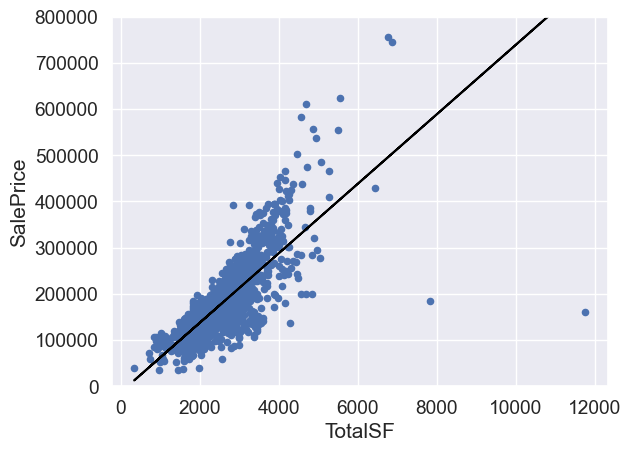

In [41]:
#scatter plot grlivarea/saleprice
var = 'TotalSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))
m, b = np.polyfit(data[var], data['SalePrice'], 1) 
plt.plot(data[var], m*data[var] + b, color='black')

In [42]:
#saleprice correlation matrix
np.corrcoef(train['TotalSF'],train['SalePrice'])

array([[1.        , 0.77910354],
       [0.77910354, 1.        ]])

As expected, the correlation with SalePrice is very strong (0.78). 

For reference, the correlation coefficients of GrLivArea and TotalBsSF are 0.71 and 0.61 respectively. 

### 6.2) Binning Neighborhoods,  MSZones, MSSubClasses, SaleCondition & SaleType ###

In [43]:
var = 'Neighborhood'
# groupby neighborhood and estimate the median sale price
median_by_nbhd = train.groupby([var])['SalePrice'].median()
median_by_nbhd.sort_values(ascending=True, inplace=True)
# groupby neighborhood and estimate the median sale price
mean_by_nbhd = train.groupby([var])['SalePrice'].mean()
mean_by_nbhd.sort_values(ascending=True, inplace=True)

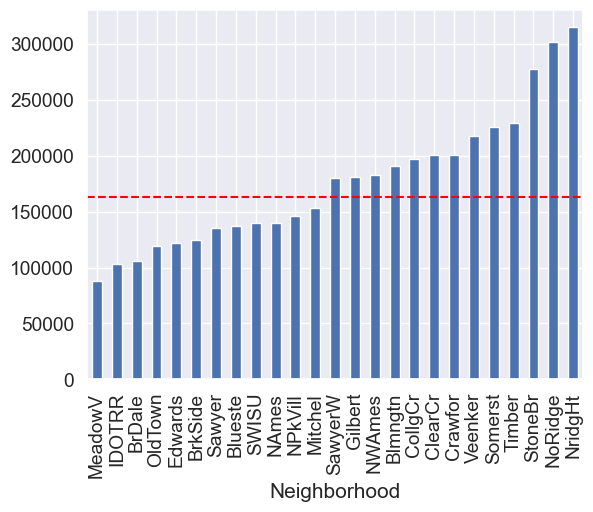

In [44]:
median_by_nbhd.plot.bar()
plt.axhline(y = median_saleprice, linestyle='dashed', color='red')

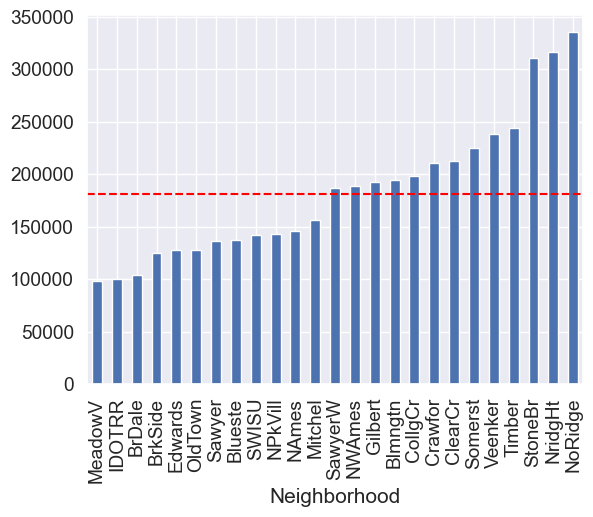

In [45]:
mean_by_nbhd.plot.bar()
plt.axhline(y = mean_saleprice, linestyle='dashed', color='red')

There are three neighborhoods whose mean and median sale price are clearly higher than the rest.

The difference between the three least affluent neighborhoods and the rest are less pronounced, but still clearly identifiable. 

We can then form another 2 clusters. The first cluster is the one whose mean and median are above the least affluent group, but still lower than the overall mean and median, and the second cluster is the one whose mean and median are below the most affluent group, but still higher than the overall mean and median. 

In [46]:
all_nbhds = list(train['Neighborhood'].unique())
neighborhoods = {}
for nbhd in all_nbhds:
    if nbhd in ['MeadowV', 'IDOTRR', 'BrDale']:
        neighborhoods[nbhd] = 1
    elif nbhd in ['StoneBr','NridgHt', 'NoRidge']:
        neighborhoods[nbhd] = 4
    elif nbhd in ['BrkSide', 'Edwards', 'OldTown', 'Sawyer', 'Blueste', 'SWISU', 'NPkVill', 'NAmes', 'Mitchel']:
        neighborhoods[nbhd] = 2
    else:
        neighborhoods[nbhd] = 3
        
train['Neighborhood'] = train['Neighborhood'].apply(lambda x: neighborhoods[x])

In [47]:
train['Neighborhood'] = pd.Categorical(train['Neighborhood'], ordered=True)
train['Neighborhood'].value_counts()

2    655
3    591
4    143
1     70
Name: Neighborhood, dtype: int64

In [48]:
var = 'MSZoning'
# groupby neighborhood and estimate the median sale price
median_by_zone = train.groupby([var])['SalePrice'].median()
median_by_zone.sort_values(ascending=True, inplace=True)
# groupby neighborhood and estimate the median sale price
mean_by_zone = train.groupby([var])['SalePrice'].mean()
mean_by_zone.sort_values(ascending=True, inplace=True)

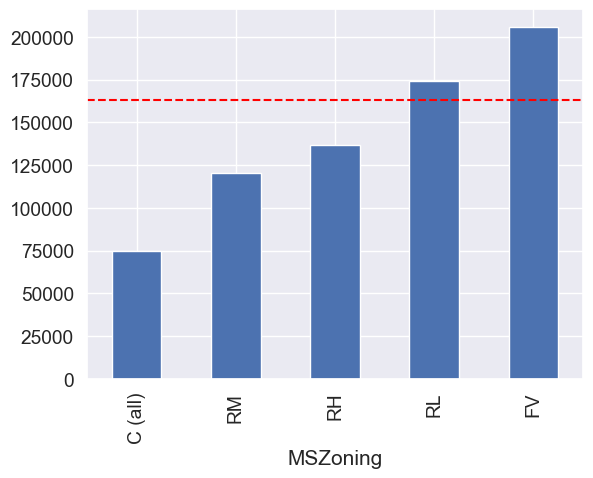

In [49]:
median_by_zone.plot.bar()
plt.axhline(y = median_saleprice, linestyle='dashed', color='red')

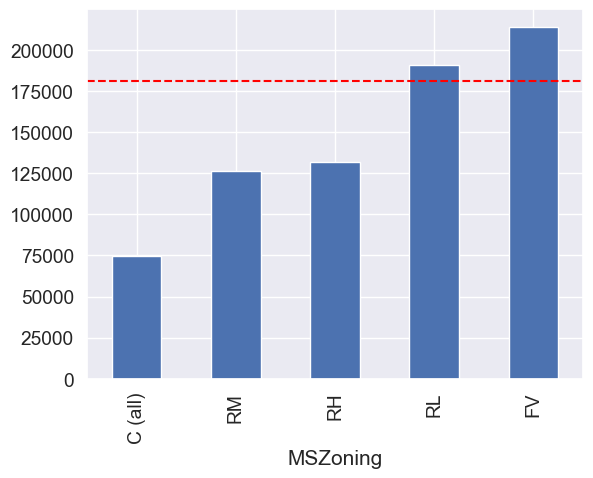

In [50]:
mean_by_zone.plot.bar()
plt.axhline(y = mean_saleprice, linestyle='dashed', color='red')

In [51]:
convert_zones = {'C (all)': 1,
                 'RM': 2,
                 'RH': 3,
                 'RL': 4,
                 'FV': 5}
        
train['MSZoning'] = train['MSZoning'].apply(lambda x: convert_zones[x])

In [52]:
var = 'MSSubClass'
# groupby MSSubClass and estimate the median sale price
median_by_subclass = train.groupby([var])['SalePrice'].median()
median_by_subclass.sort_values(ascending=True, inplace=True)
# groupby MSSubClass and estimate the median sale price
mean_by_subclass = train.groupby([var])['SalePrice'].mean()
mean_by_subclass.sort_values(ascending=True, inplace=True)

In [53]:
train.groupby([var])['SalePrice'].count()

MSSubClass
20     536
30      69
40       4
45      12
50     144
60     299
70      60
75      16
80      57
85      20
90      52
120     87
160     63
180     10
190     30
Name: SalePrice, dtype: int64

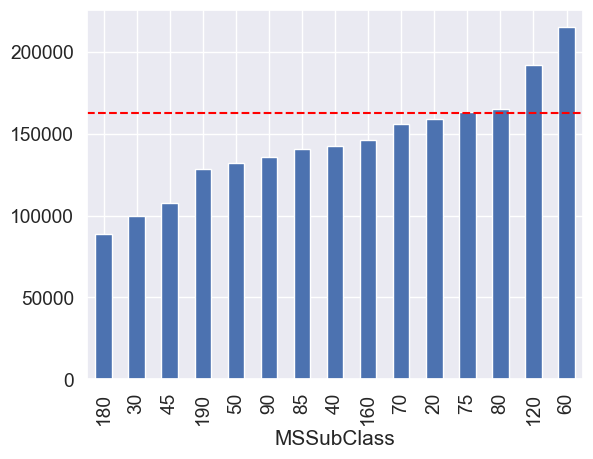

In [54]:
median_by_subclass.plot.bar()
plt.axhline(y = median_saleprice, linestyle='dashed', color='red')

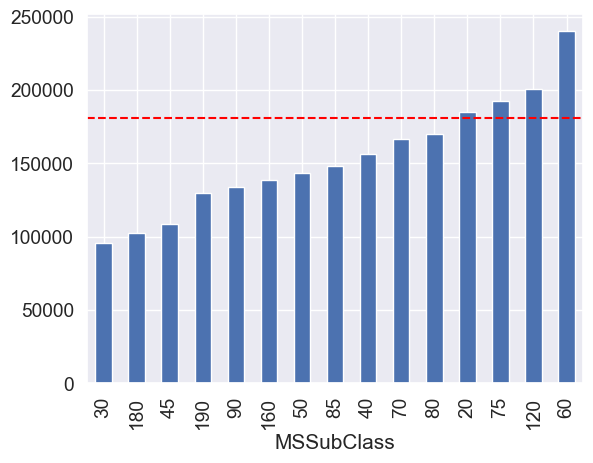

In [55]:
mean_by_subclass.plot.bar()
plt.axhline(y = mean_saleprice, linestyle='dashed', color='red')

In [56]:
all_subclasses = list(train['MSSubClass'].unique())
subclasses = {}
for subclass in all_subclasses:
    if subclass in ['30', '180', '45']:
        subclasses[subclass] = 1
    elif subclass == '60':
        subclasses[subclass] = 5
    elif subclass == '120':
        subclasses[subclass] = 4
    elif subclass in ['190', '90', '50', '85', '40', '160']:
        subclasses[subclass] = 2
    else:
        subclasses[subclass] = 3
        
        
train['MSSubClass'] = train['MSSubClass'].apply(lambda x: subclasses[x])

In [57]:
train['SaleCondition'].value_counts()

Normal     1197
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [58]:
all_saleconditions = list(train['SaleCondition'].unique())
saleconditions = {}
for condition in all_saleconditions:
    if condition in ['AdjLand', 'Alloca', 'Family']:
        saleconditions[condition] = 1
    elif condition == 'Abnorml':
        saleconditions[condition] = 2
    elif condition == 'Partial':
        saleconditions[condition] = 3
    else:
        saleconditions[condition] = 4

train['SaleCondition'] = train['SaleCondition'].apply(lambda x: saleconditions[x])

In [59]:
train['SaleType'].value_counts()

WD       1266
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [60]:
all_saletypes = list(train['SaleType'].unique())
saletypes = {}
for saletype in all_saletypes:
    if saletype in ['Con', 'Oth', 'CWD', 'ConLw', 'ConLI', 'ConLD']:
        saletypes[saletype] = 1
    elif saletype == 'COD':
        saletypes[saletype] = 2
    elif saletype == 'New':
        saletypes[saletype] = 3
    else:
        saletypes[saletype] = 4

train['SaleType'] = train['SaleType'].apply(lambda x: saletypes[x])

### 6.3) Adding 'House Age', 'Remodeled (Yes/No) and IsNew Variables ###

In [61]:
train[['YearBuilt','YearRemodAdd']]

,YearBuilt,YearRemodAdd
0,2003,2003
1,1976,1976
2,2001,2002
3,1915,1970
4,2000,2000
...,...,...
1454,1999,2000
1455,1978,1988
1456,1941,2006
1457,1950,1996


YearRemodAdd defaults to YearBuilt if there has been no remodelling or addition. We can use YearRemodAdd and YearSold to determine the age of the house. This would give an indication of how newly furnished the house is.

However, we should acknowledge that a house that has been remodelled is likely to be worth less than a house which was newly built in the same year still. Hence we can add a Remodelled Yes/No variable that would act as some sort of penalty parameter. 

In [62]:
train['Age'] = train['YrSold'] - train['YearRemodAdd']
train['Remodelled'] = train.apply(lambda x: 0 if (x['YearBuilt'] == x['YearRemodAdd']) else 1, axis=1)

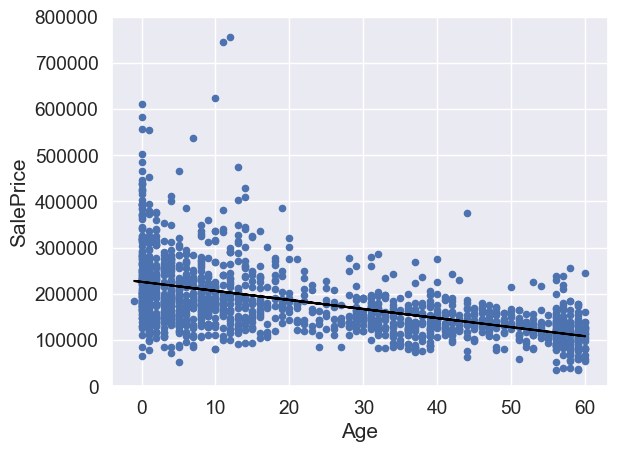

In [63]:
#scatter plot grlivarea/saleprice
var = 'Age'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))
m, b = np.polyfit(data[var], data['SalePrice'], 1) 
plt.plot(data[var], m*data[var] + b, color='black')

As expected, the age of the house and its sale price are negatively correlated.

In [64]:
#saleprice correlation matrix
np.corrcoef(train['Age'],train['SalePrice'])

array([[ 1.        , -0.50940454],
       [-0.50940454,  1.        ]])

In [65]:
train.groupby('Remodelled')['SalePrice'].agg('mean')

Remodelled
0    182583.659686
1    179112.992806
Name: SalePrice, dtype: float64

Houses that are remodelled appear to sell for less than houses which are not, though not by much.

Finally, let's create the IsNew variable. Here we are assuming that houses which are brand new are worth more, so there's a non-linear drop-off in SalePrice as compared to just using the age of the house.

In [66]:
train['IsNew'] = train.apply(lambda x: 1 if (x['YrSold'] == x['YearBuilt']) else 0, axis=1)

Let's convert these two variables into categorical variables. Note that we can treat YrSold as an ordinal variable, since a house sold before or after a particular year has a clear meaning on its own. MoSold, however, should be treated as a nominal variable since we cannot ascertain whether an event happened before or after another month with just the month alone. 

In [67]:
train['YrSold'] = pd.Categorical(train['YrSold'], ordered=True)
train['MoSold'] = pd.Categorical(train['MoSold'], ordered=False)

### 6.4) Total Number of Bathrooms ###

We also have four bathroom variables. Let's combine all of them into one and see how well it correlates with SalePrice.

In [68]:
bathroom_vars = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']
train[bathroom_vars].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   BsmtFullBath  1459 non-null   int64
 1   BsmtHalfBath  1459 non-null   int64
 2   FullBath      1459 non-null   int64
 3   HalfBath      1459 non-null   int64
dtypes: int64(4)
memory usage: 45.7 KB


In [69]:
train[bathroom_vars].head()

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
0,1,0,2,1
1,0,1,2,0
2,1,0,2,1
3,1,0,1,0
4,1,0,2,1


In [70]:
train['TotalBath'] = train['BsmtFullBath'] + 0.5*train['BsmtHalfBath'] + train['FullBath'] + 0.5*train['HalfBath']

In [71]:
pd.concat([train['SalePrice'], train[bathroom_vars], train['TotalBath']], axis=1).corr()

,SalePrice,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotalBath
SalePrice,1.000000,0.227082,-0.016873,0.560881,0.284400,0.631809
BsmtFullBath,0.227082,1.000000,-0.148044,-0.064097,-0.030238,0.583444
BsmtHalfBath,-0.016873,-0.148044,1.000000,-0.054418,-0.012144,0.012154
FullBath,0.560881,-0.064097,-0.054418,1.000000,0.135815,0.694178
HalfBath,0.284400,-0.030238,-0.012144,0.135815,1.000000,0.393427
TotalBath,0.631809,0.583444,0.012154,0.694178,0.393427,1.000000


The total number of bathrooms captures information from all the other bathroom variables, and is the most correlated with SalePrice. 

### 6.5) Consolidating Porch Variables ###

There are 5 variables related to porches and decks:
- WoodDeckSF: Wood deck area in square feet
- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet

A porch is an addition to the entryway while a deck is generally built in the backyard and serves as a recreational area. So we can leave WoodDeckSF alone and consolidate the other 4 variables:

In [72]:
train['TotalPorchSF'] = train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']

In [73]:
porch_vars = ['TotalPorchSF', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

In [74]:
pd.concat([train['SalePrice'], train[porch_vars]], axis=1).corr()

,SalePrice,TotalPorchSF,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
SalePrice,1.000000,0.195691,0.324422,0.315831,-0.128627,0.044571,0.111419
TotalPorchSF,0.195691,1.000000,-0.084703,0.613392,0.468012,0.236679,0.519937
WoodDeckSF,0.324422,-0.084703,1.000000,0.058693,-0.125983,-0.032767,-0.074175
OpenPorchSF,0.315831,0.613392,0.058693,1.000000,-0.093273,-0.005900,0.074188
EnclosedPorch,-0.128627,0.468012,-0.125983,-0.093273,1.000000,-0.037336,-0.082937
3SsnPorch,0.044571,0.236679,-0.032767,-0.005900,-0.037336,1.000000,-0.031458
ScreenPorch,0.111419,0.519937,-0.074175,0.074188,-0.082937,-0.031458,1.000000


Interestingly, Sale price correlates the most with WoodDeckSF and OpenPorchSF. The other porch variables have a very weak correlation with sale price. We'll use WoodDeckSF and OpenPorchSF as our candidate variables instead. 

# 7) Preparing Data for Modelling #

## 7.1) Scaling Numeric Predictors ##

Before scaling the numeric predictors, we'll first need to distinguish between our categorical and numeric variables in the dataset.

In [75]:
def convert_categorical(df, col_index):
    df.iloc[:, col_index] = pd.Categorical(df.iloc[:,col_index])
    return df

In [76]:
categorical_indices = [0, 1, 2, 14, 15, 16, 17, 18, 57, 58, 60, 61, 64, 65, 66]

In [77]:
for i in categorical_indices:
    train = convert_categorical(train, i)

/var/folders/lw/rrbkgcqn1rd5b065dkf8ctwr0000gn/T/ipykernel_66605/2914381381.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, col_index] = pd.Categorical(df.iloc[:,col_index])


We'll remove the numeric predictors that are either highly correlated with another important predictor we are already including, or that do not correlate strongly with SalePrice.

In [78]:
#These variables are included in engineered feature - TotalSF
train.drop(columns=['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea'], inplace=True)
train.drop(columns=['1stFlrSF', '2ndFlrSF', 'LowQualFinSF'], inplace=True)
#These variables are included in engineered feature - TotalBath
train.drop(columns=['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace=True)
#Important porch variables are WoodenDeckSF and OpenPorchSF
train.drop(columns=['EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'TotalPorchSF'], inplace=True)
#GarageArea is highly correlated with GarageCars
train.drop(columns=['GarageArea'], inplace=True)
#BedroomAbvGr and TotRmsAbvGrd are highly correlated with TotalSF
train.drop(columns=['BedroomAbvGr', 'TotRmsAbvGrd'], inplace=True)

Now we can extract the numeric columns and perform standard scaling.

In [79]:
#Extract Numeric Columns

numerics = ['int64','float64']
numeric_cols = train.select_dtypes(include=numerics)
numeric_cols.drop(columns=['SalePrice'], inplace=True)

In [80]:
#Using Standard Scaling on Numeric Columns 

std_scaler = StandardScaler()
 
df_scaled = std_scaler.fit_transform(numeric_cols.to_numpy())
numeric_vars = pd.DataFrame(df_scaled, columns = numeric_cols.columns)

In [81]:
#Checking for correlated variables

c = numeric_vars.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")

In [82]:
so[-20:-9]

TotalBath    Fireplaces     0.332011
OpenPorchSF  TotalSF        0.342104
TotalSF      OpenPorchSF    0.342104
Fireplaces   TotalSF        0.475086
TotalSF      Fireplaces     0.475086
TotalBath    GarageCars     0.483537
GarageCars   TotalBath      0.483537
TotalSF      GarageCars     0.530001
GarageCars   TotalSF        0.530001
TotalBath    TotalSF        0.600973
TotalSF      TotalBath      0.600973
dtype: float64

## 7.2) One-Hot Encoding for Nominal Variables ##

In [83]:
#Extract Categorical Columns
categorical_cols = train.select_dtypes(include=['object','category'])

#Drop ordinal variables
categorical_cols.drop(columns=['Age','OverallQual', 'OverallCond','ExterQual','ExterCond','KitchenQual'], inplace=True)

In [84]:
transformer = make_column_transformer(
    (OneHotEncoder(drop='first', min_frequency = 10), list(categorical_cols.columns)),
    remainder='passthrough')

transformed = transformer.fit_transform(categorical_cols)
transformed_df = pd.DataFrame.sparse.from_spmatrix(transformed, columns = transformer.get_feature_names_out())

In [85]:
threshold = 10
#dropping all columns with fewer than 10 'ones'
nominal_vars = transformed_df[transformed_df.columns[transformed_df.sum() > threshold]]

## 7.3) Ordinal Encoding for Ordinal Variables ##

In [86]:
#Examining Ordinal Variables
ordinal_vars = train[['Age','OverallQual', 'OverallCond','ExterQual','ExterCond','KitchenQual']]
ordinal_vars.head()

,Age,OverallQual,OverallCond,ExterQual,ExterCond,KitchenQual
0,5,7,5,Gd,TA,Gd
1,31,6,8,TA,TA,TA
2,6,7,5,Gd,TA,Gd
3,36,7,5,TA,TA,Gd
4,8,8,5,Gd,TA,Gd


In [87]:
ordinal_encoding = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'NA': 0
}

In [88]:
for col_name in ['ExterQual', 'ExterCond', 'KitchenQual']:
    ordinal_vars[col_name] = ordinal_vars[col_name].apply(lambda x: ordinal_encoding[x])

/var/folders/lw/rrbkgcqn1rd5b065dkf8ctwr0000gn/T/ipykernel_66605/2455652573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordinal_vars[col_name] = ordinal_vars[col_name].apply(lambda x: ordinal_encoding[x])


In [89]:
#Composing our training data
X = pd.concat([numeric_vars, ordinal_vars, nominal_vars], axis=1)

In [90]:
nominal_vars

,onehotencoder__MSZoning_2,onehotencoder__MSZoning_3,onehotencoder__MSZoning_4,onehotencoder__MSZoning_5,onehotencoder__LotShape_IR2,onehotencoder__LotShape_Reg,onehotencoder__LandContour_HLS,onehotencoder__LandContour_Low,onehotencoder__LandContour_Lvl,onehotencoder__LotConfig_CulDSac,...,onehotencoder__YrSold_2009,onehotencoder__YrSold_2010,onehotencoder__SaleType_2,onehotencoder__SaleType_3,onehotencoder__SaleType_4,onehotencoder__SaleCondition_2,onehotencoder__SaleCondition_3,onehotencoder__SaleCondition_4,onehotencoder__Remodelled_1,onehotencoder__IsNew_1
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1455,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1456,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1457,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [91]:
#Using log transform on Sale Price
y = np.log(train['SalePrice'])

## Outliers ##




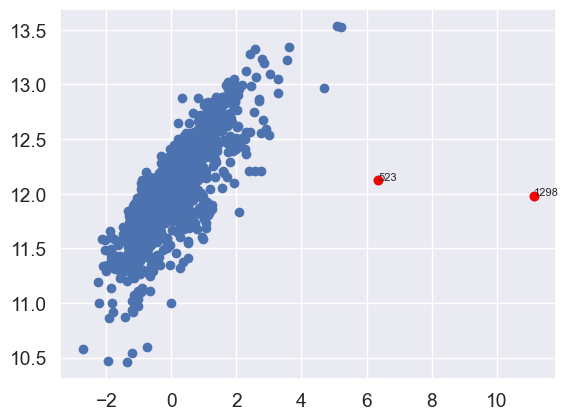

In [92]:
fig, ax = plt.subplots()
ax.scatter(X['TotalSF'], y)
bool_mask = X['TotalSF'] > 6
ax.scatter(X[bool_mask]['TotalSF'], y[bool_mask], color='red')
n = X[bool_mask].index

for i in range(0, X[bool_mask].shape[0]):
    ax.annotate((X[bool_mask]['TotalSF'].index[i]),
               (X[bool_mask]['TotalSF'].iloc[i], y[bool_mask].iloc[i]),
               fontsize=8)

In [93]:
#Let's examine the 2 points which are very far away from the rest of the dataset in the TotalSF variable
X[X['TotalSF'] > 6]

,LotArea,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,PoolArea,TotalSF,TotalBath,Age,...,onehotencoder__YrSold_2009,onehotencoder__YrSold_2010,onehotencoder__SaleType_2,onehotencoder__SaleType_3,onehotencoder__SaleType_4,onehotencoder__SaleCondition_2,onehotencoder__SaleCondition_3,onehotencoder__SaleCondition_4,onehotencoder__Remodelled_1,onehotencoder__IsNew_1
523,2.963221,-0.211529,0.599824,1.650010,0.907616,5.423942,-0.068715,6.365039,2.915321,-1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
1298,5.346992,-0.211529,3.703166,0.311842,0.955486,3.703051,11.878347,11.148024,2.915321,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


Let's remove the two outliers for now. 

In [94]:
#remove observation with index 523 and 1298
X = X.drop([523, 1298], axis=0)
y = y.drop([523, 1298])